Necessary imports for code execution:

In [24]:
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from plotly import figure_factory as ff

Importing dataset: Polish Companies Bankruptcy. The data contains financial rates from 3rd year of the forecasting period and corresponding class label that indicates bankruptcy status after 3 years.

In [25]:
uploaded = files.upload()

Saving bankruptcy.csv to bankruptcy (1).csv


In [26]:
df3 = pd.read_csv('./Data/Bankruptcy/bankruptcy.csv')
df3.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (14,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,class
0,0.174190,0.41299,0.14371,1.348,-28.982,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.16396,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.19,3.5716,5.95,0
2,0.000595,0.22612,0.48839,3.1599,84.874,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.0076387,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.105,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.9516,0.142980,4.2286,5.0528,98.783,3.695,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.274,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.17648,0.321880,0.82635,0.073039,2.5912,7.0756,100.54,3.6303,4.6375,0


In [5]:
print(f"Class distribution in dataset:\n{df3.groupby('class').size()}")

Class distribution in dataset:
class
0    10008
1      495
dtype: int64


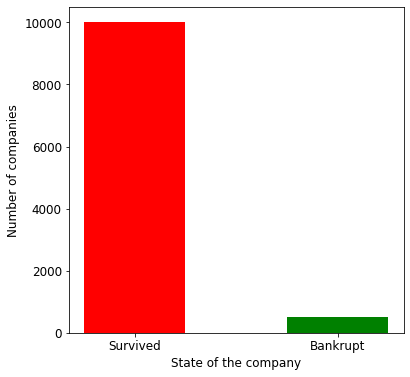

<Figure size 432x288 with 0 Axes>

In [27]:
# Dataset generation for plot
data_dict = {'Survived':10008,'Bankrupt':495}
courses = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (6, 6))

#  Bar plot
plt.bar( courses, values, color ={ 'green','red'},
        width = 0.5)
plt.xlabel("State of the company")
plt.ylabel("Number of companies")
plt.title("")
plt.rcParams.update({'font.size': 12})
plt.show()
plt.savefig('classes.png', bbox_inches='tight')

This dataset is an imbalanced dataset when it comes to class distribution (495:10008).

The original data contains "?" values that stand for missing records. They are replaced with NaN values.

In [28]:
for col in df3:
  column = df3[col]
  column.replace({"?": np.nan}, inplace=True)

In [7]:
idx = df3.isin([np.nan]).any(axis=1)
df3[idx]

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,class
1,0.146240,0.46038,0.282300,1.6294,2.5952,0.000000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.19,3.5716,5.95,0
2,0.000595,0.22612,0.488390,3.1599,84.874,0.191140,0.004572,2.9881,1.0077,0.67566,...,0.0076387,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
5,0.182060,0.55615,0.321910,1.6045,16.314,0.000000,0.182060,0.79808,1.8126,0.44385,...,0.55577,0.410190,0.46957,0.029421,8.4553,3.3488,107.24,3.4036,12.454,0
8,0.238950,0.55473,0.406970,1.7609,-22.907,0.000000,0.297140,0.80268,2.3317,0.44527,...,0.14038,0.536630,0.87292,0.044584,4.4527,7.1847,83.727,4.3594,40.097,0
9,-0.119860,0.60733,0.041368,1.0688,-37.595,-0.447970,-0.119860,0.64655,3,0.39267,...,0.26428,-0.305250,0.73749,0.000000,12.844,8.3043,73.172,4.9883,8.3984,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497,0.003840,0.62783,0.113260,1.1997,-74.437,0.003840,0.008917,0.58625,0.95419,0.36806,...,-0.048013,0.010434,1.048,0.164940,3.2544,3.2163,190.36,1.9175,3.4024,1
10498,0.002861,0.58067,-0.223860,0.51658,-31.866,0.002861,0.002861,0.61855,1.012,0.35917,...,0.011834,0.007966,0.98817,0.327360,38.142,39.15,42.202,8.6489,5.2646,1
10499,-0.051968,0.55254,0.147150,2.1698,12.748,-0.051968,-0.034361,0.66983,0.94694,0.37011,...,-0.056037,-0.140410,1.056,1.153000,14.493,9.2851,32.761,11.141,1.9276,1
10500,-0.135900,0.83954,-0.342010,0.46526,-145.31,-0.219120,-0.131860,0.19113,1.0999,0.16046,...,0.14412,-0.846930,0.85427,0.814200,6.2737,9.6966,212.23,1.7198,1.5659,1


5618 records contain missing values.

In [8]:
attributes = df3.isnull().sum()/10503*100
type(attributes)
attributes.columns=['att', 'number']
attributes = attributes[:64,]

Below we can see the first six records with the biggest number of missing values.

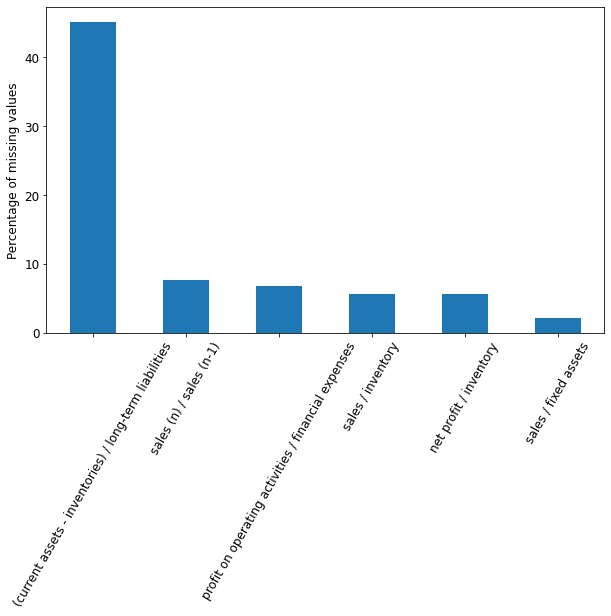

In [29]:
attributes = attributes.sort_values( ascending = False)
attributes = attributes[:6,]

fig = plt.figure(figsize = (10,6))
ax = attributes.plot.bar(x ='att', y = 'number')
# plt.xlabel("Attributes")
plt.ylabel("Percentage of missing values")
plt.title("")
plt.xticks(rotation=60)
plt.show()

In [17]:
# preparing data for the models
data = df3.iloc[:,:64]
classes = df3['class'].to_numpy()
dataset = data.to_numpy()
dataset.shape

(10503, 64)

In [30]:
# standardizing data
dataset_std = StandardScaler().fit_transform(dataset)
df_standarize = pd.DataFrame(data = dataset_std)
df_standarize.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.187329,-0.032197,0.007511,-0.016485,0.011121,0.104011,0.236263,-0.025104,-0.082196,0.015167,...,2.010730,0.012399,0.020904,-0.015841,-0.018498,-0.015117,-0.091446,-0.001945,-0.151662,-0.074094
1,0.144181,-0.024823,0.029099,-0.015947,0.011388,0.017382,0.163143,-0.025035,-0.028683,0.026994,...,-0.054297,0.009961,0.015298,-0.015499,-0.018498,-0.015217,-0.117384,-0.001256,-0.175811,-0.069620
2,-0.080661,-0.061274,0.061202,-0.013025,0.012082,0.044804,-0.093765,-0.022505,-0.107047,0.048157,...,0.230789,0.009606,0.000840,-0.015019,-0.018498,-0.015196,-0.121185,-0.002692,-0.110335,-0.073104
3,-0.043717,-0.029183,0.028034,-0.015653,0.011280,0.099077,-0.063120,-0.024849,-0.101349,0.030869,...,-0.027154,0.010334,0.003118,-0.015233,-0.016647,-0.015264,-0.106124,-0.001387,-0.171883,-0.075377
4,0.209096,-0.031878,0.038447,-0.015377,0.010874,0.017382,0.257948,-0.024704,-0.063308,0.034048,...,0.118476,0.012623,0.018021,-0.015892,-0.017553,-0.015308,-0.081956,-0.001320,-0.173942,-0.072685


In [31]:
# calculating scale_pos_weight parameter for Weighted XGBoost for Class Imbalance

counter = Counter(classes)
print(counter)
scale_pos_weight = counter[0] / counter[1]
scale_pos_weight

Counter({0: 10008, 1: 495})


20.21818181818182

In [35]:
#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_std.reshape(10503,64), classes, test_size = 0.2, random_state = 0)

In [36]:
# defining metrics
def eval_model(y_test, predictions):
    """
    This function evaluates model using four metrics
    inputs:
    y_test: ground truth
    predictions: results of our model

    """

    print("Accuracy of Model:",accuracy_score(y_test,predictions))
    print("F1 score of Model:",f1_score(y_test,predictions))
    print('Confusion Matrix:', confusion_matrix(y_test,predictions))
    print("Precision score of Model:",precision_score(y_test,predictions))
    print("Recall score of Model:",recall_score(y_test,predictions))
    print(f"Number of predictions of 1: {len(predictions[predictions==1])}")
    print(f"Number of predictions of 0: {len(predictions[predictions==0])}")

In [61]:
# defining confusion matrix function
def plot_confusion_matrix(cm, method):
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['Survived', 'Bankrupt'], index=['Bankrupt', 'Survived'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice',  reversescale=True)
    fig.layout.xaxis.update({'title': 'Predicted Label'})
    fig['layout']['xaxis']['side'] = 'bottom'
    fig.layout.yaxis.update({'title': 'True Label'})
    fig.update_layout(width=400, height=400, title=f'Confusion Matrix for {method}', font_size=16)
    fig.show()

**XGBoost Classifer**

In [33]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 objective='multi:softmax',
 nthread=4,
 num_class = 2,
 scale_pos_weight=scale_pos_weight)

xgb_classifier.fit(X_train,y_train)
xgb_pred = xgb_classifier.predict(X_test)

In [38]:
XGB_scores = eval_model(y_test, xgb_pred)

Accuracy of Model: 0.9690623512613041
F1 score of Model: 0.5517241379310345
Confusion Matrix: [[1996   10]
 [  55   40]]
Precision score of Model: 0.8
Recall score of Model: 0.42105263157894735
Number of predictions of 1: 50
Number of predictions of 0: 2051


In [62]:
fig1 = plot_confusion_matrix(confusion_matrix(y_test, xgb_pred), 'XGBoost')

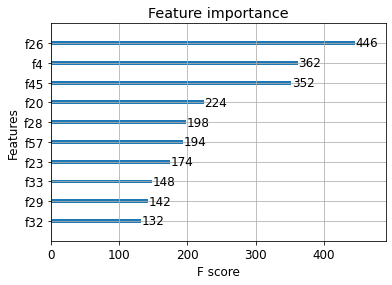

In [84]:
xgb.plot_importance(xgb_classifier, max_num_features = 10)

The plot represents the 10 most important features when it comes to the XGB classifier:


*  f26 - gross profit (in 3 years) / total assets
*  f4 - current assets / short-term liabilities
*  f45 - rotation receivables + inventory turnover in days
*  f20 - (inventory * 365) / sales
*  f28 - (net profit + depreciation) / total liabilities
*  f57 - working capital
*  f23 - net profit / sales
*  f33 - (gross profit + interest) / sales
*  f29 - profit on operating activities / financial expenses
*  f32 - (total liabilities - cash) / sales



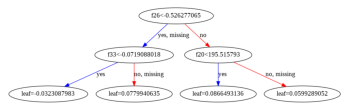

In [71]:
xgb.plot_tree(xgb_classifier, num_trees=2)

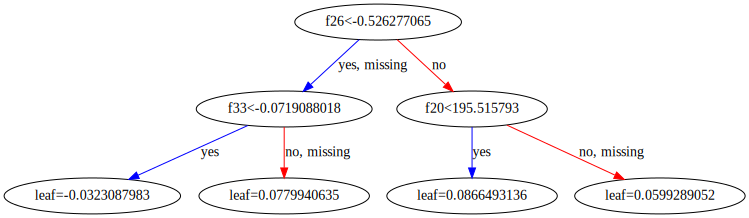

In [72]:
xgb.to_graphviz(xgb_classifier, num_trees=2)

**SVM Model**

In [73]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)
    
clf = svm.SVC(kernel='rbf', random_state = 1, class_weight='balanced')
clf = clf.fit(X_train_imp, y_train)
svm_pred = clf.predict(X_test_imp)

SVM does not handle NaN values. In order to be able to fit the model, the missing values were imputed as mean values of each column in which the missing values are located.

In [74]:
SVM_scores = eval_model(y_test, svm_pred)

Accuracy of Model: 0.6639695383150881
F1 score of Model: 0.1635071090047393
Confusion Matrix: [[1326  680]
 [  26   69]]
Precision score of Model: 0.09212283044058744
Recall score of Model: 0.7263157894736842
Number of predictions of 1: 749
Number of predictions of 0: 1352


In [75]:
fig2 = plot_confusion_matrix(confusion_matrix(y_test, svm_pred), 'SVM')

**Logistic Regression**

Logistic Regression does not handle NaN values - imputed datasets from previous example were used. For this task, also the weigths to balance the class distribution were specified.

In [76]:
weights = {0:1, 1:20}

In [77]:
regr = LogisticRegression(random_state=0, class_weight="balanced", solver='lbfgs', max_iter=1000).fit(X_train_imp, y_train)
regr_pred = regr.predict(X_test_imp)

In [78]:
regr_scores = eval_model(y_test, regr_pred)

Accuracy of Model: 0.6587339362208472
F1 score of Model: 0.15348288075560804
Confusion Matrix: [[1319  687]
 [  30   65]]
Precision score of Model: 0.08643617021276596
Recall score of Model: 0.6842105263157895
Number of predictions of 1: 752
Number of predictions of 0: 1349


In [79]:
fig3 = plot_confusion_matrix(confusion_matrix(y_test, regr_pred), 'Regression')